In [1]:
# Add parent directory
from sys import path as sysPath
sysPath.append('../')

# Add custom modules
sysPath.append('../Machine_Score/')

from Support_Code import general_module as gm
from Support_Code import info_module as im
from Image_Creator import main_image_creator as ic
from Machine_Score import main_machine_score as ms
from Machine_Score import direct_image_compare as dc
from Score_Analysis import main_score_analysis as sa
import main_SIMR as simr

# General modules
from os import path
import numpy as np
from matplotlib import pyplot as plt

sa.test()
gm.test()
im.test()
ic.test()
ms.test()
dc.test()
simr.test()

SA: Hi!  You're in Matthew's Main program for score analysis!
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew Ogden's information module for SPAM
IC: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DI: Hi!  You're in direct_image_compare.py
SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions


In [2]:
#tDir = '/home/mbo2d/galStuff/spam_data_pl3/587722984435351614/' 
#tDir = '../../targetDir/'
tDir = '../../1237678620102623480/'

tInfo = im.target_info_class( targetDir = tDir, printAll=True)

if tInfo.status == False:
    print("WARNING")
else:
    print("Target Good!")

IM: target_info_class.__init__:
	 - targetDir:  ../../1237678620102623480/
IM: Target.initTargetDir():
	 - targetDir: ../../1237678620102623480/
NEW PATH EXISTS: /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/
	 - targetDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/
	 - infoDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/information/
	 - baseInfoLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/information/base_target_info.json
	 - allInfoLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/information/target_info.json
	 - zooMergerDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/
	 - plotDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/plots/
IM: Target: Opening target info json
Target Good!


In [3]:

print(tInfo.get('zoo_merger_models').get('00001'))

rId = 'r00001'
runArg = gm.inArgClass()
runArg.setArg("printAll",True)
runArg.setArg("tInfo",tInfo)

rInfo = tInfo.getRunInfo( rID=rId, rArg = runArg)
rInfo.tInfo = tInfo

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))
    print(rInfo.get('tInfo').status)

None
IM: run_info_class.__init__
	 - runDir:  /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/
IM: run.initRunDir
	 - runDir: /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/
	 - runDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/
	 - ptsDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/particle_files/
	 - imgDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/model_images/
	 - miscDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/misc_images/
	 - infoLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/info.json
	 - baseLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/base_i

In [13]:
# If you need to create a brand new json score parameter

from copy import deepcopy
pLoc = gm.validPath('../param/start_param.json')
print(pLoc,'\n')
oldParams = im.group_score_parameter_class(pLoc = pLoc)
params = oldParams.group
gm.pprint(params)

params['base0_ssim'] = deepcopy( params['base_score'] )

params['base0_ssim']['name'] = 'base0_ssim'
params['base0_ssim']['cmpArg']['cmpMethod'] = 'ssim'

params.pop('base_score',None)
params.pop('base_perturbation',None)

gm.pprint(params)

newParams = im.group_score_parameter_class( params = params )
newParams.saveParam( saveLoc = '../param/ssim.json')


/mnt/c/Users/ogden/OneDrive/Desktop/galStuff/galaxyJSPAM/param/start_param.json 

{'base_perturbation': {'cmpArg': {'cmpMethod': 'correlation'},
                       'imgArg': {'name': 'default',
                                  'pType': 'default'},
                       'name': 'base_perturbation',
                       'scoreType': 'perturbation',
                       'simArg': {'nPts': '100k',
                                  'name': '100k'}},
 'base_score': {'cmpArg': {'cmpMethod': 'correlation'},
                'imgArg': {'name': 'default',
                           'pType': 'default'},
                'name': 'base_score',
                'scoreType': 'target',
                'simArg': {'nPts': '100k',
                           'name': '100k'},
                'targetName': 'zoo'}}
{'base0_ssim': {'cmpArg': {'cmpMethod': 'ssim'},
                'imgArg': {'name': 'default',
                           'pType': 'default'},
                'name': 'base0_ssim',
        

In [14]:
pLoc = gm.validPath('../param/ssim.json')
print(pLoc,'\n')
newParam = im.group_score_parameter_class(pLoc = pLoc)
if newParam.status == True:
    new_params = newParam.group
    print("New Score Params Good!")
    gm.pprint(params)
else:
    print("Failed to load new params")

/mnt/c/Users/ogden/OneDrive/Desktop/galStuff/galaxyJSPAM/param/ssim.json 

New Score Params Good!
{'base0_ssim': {'cmpArg': {'cmpMethod': 'ssim'},
                'imgArg': {'name': 'default',
                           'pType': 'default'},
                'name': 'base0_ssim',
                'scoreType': 'target',
                'simArg': {'nPts': '100k',
                           'name': '100k'},
                'targetName': 'zoo'}}


IM: Loading imgLoc: default False


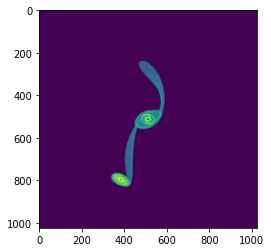

In [6]:
img1 = rInfo.getModelImg( params['new_score']['imgArg']['name'] )
plt.imshow(img1)

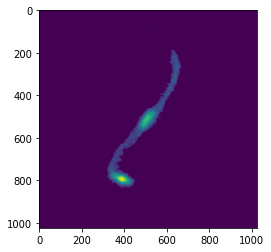

In [7]:
img2 = tInfo.getTargetImage( params['new_score']['targetName'] )
plt.imshow(img2)

In [12]:
from skimage.metrics import structural_similarity as ssim

def score_ssim( img1, img2 ):
    score = 0
    score = ssim( img1, img2 )
    return score

score = new_image_compare( img1, img2 )
print(score)

0.9488813198644631


In [9]:
print(dc.test_compare)

dc.set_test_compare(score_ssim)

print(dc.test_compare)

None
<function new_image_compare at 0x7fd5fd498790>


In [10]:
newRunScoreArg = gm.inArgClass()
newRunScoreArg.setArg( 'rInfo', rInfo )
newRunScoreArg.setArg( 'scoreParams', new_params )
newRunScoreArg.setArg( 'printAll', True )
newRunScoreArg.setArg( 'newScore', True )

simr.simr_run( rInfo = rInfo, arg = newRunScoreArg )


SIMR.pipelineRun: Inputs
	 - rDir: None
	 - rInfo: <class 'Support_Code.info_module.run_info_class'>
SIMR.pipelineRun: 
	 - rInfo:  <Support_Code.info_module.run_info_class object at 0x7fd5fcc28fa0>
MS: Run:
MS: scoreName: new_score
MS: target_image_compare: test_compare
	 -  paramName: test_compare
	 -  modelName: default
	 - targetName: zoo
	 - Read target image
IM: Loading imgLoc: default False
MS: run: Read model image
IM: Run.saveInfoFile: Saving info data file...
MS: scoreName: new_perturbation
MS: perturbation_compare: test_perturbation
	 -  paramName: test_perturbation
	 -  modelName: default
MS: perturbation_compare: Read model image: default
IM: Loading imgLoc: default True
MS: perturbation_compare: Read init image: default
IM: Run.saveInfoFile: Saving info data file...


SIMR: pipelineTarget: input
	 - tDir: None
	 - tInfo: <class 'NoneType'>
SIMR: simr_target status:
	 - tInfo.status: True
SIMR: new_target_scores:
	 - tInfo: True
	 - Runs needing scores: 44
Process-11 - queue empty
Process-10 - queue empty
Process-9 - queue empty
IM: Target.gatherRunInfos.
GM: Printing Input arguments
	- printBase - <class 'bool'> :  True
	- printAll - <class 'bool'> :  False
	- nProc - <class 'int'> :  -1
	- simple - <class 'bool'> :  False
	- runDir - <class 'NoneType'> :  None
	- sdssDir - <class 'NoneType'> :  None
	- targetDir - <class 'NoneType'> :  None
	- dataDir - <class 'NoneType'> :  None
Process-14 - queue emptyProcess-12 - queue empty

Process-13 - queue empty
IM: Target.saveInfoFile():
	 - Saving target info file...
IM: Target.saveInfoFile():
	 - Saving target info file...
IM: Target.saveInfoFile():
	 - Saving target info file...
Target Machine Scores Found: 14
	 - base_score
	 - base0_corr
	 - base0_diff
	 - base0_diff_scale
	 - base0_diff_scale1
	 - ba

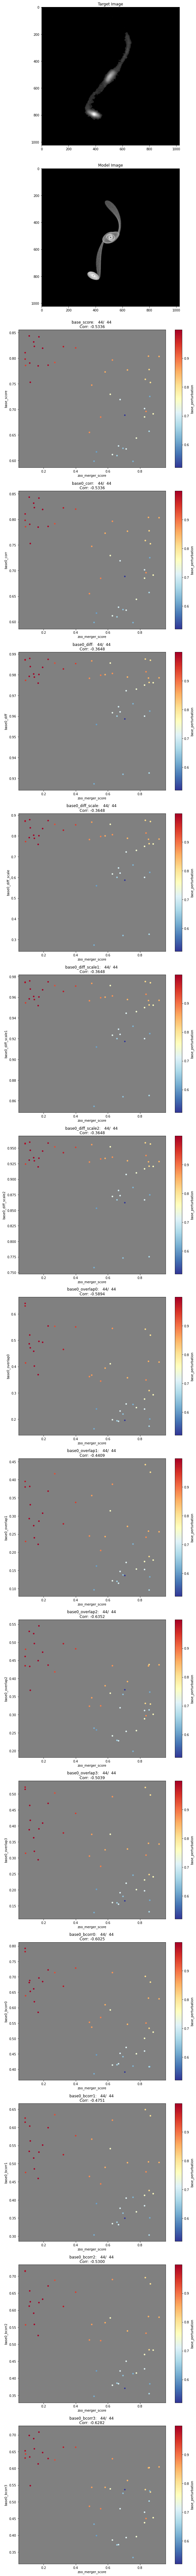

In [15]:
newTarget = gm.inArgClass()
newTarget.setArg( 'tInfo', tInfo )
newTarget.setArg( 'paramLoc', '../param/ssim.json' )
newTarget.setArg( 'printAll', False )
newTarget.setArg( 'newScore', True )

simr.simr_target( arg=newTarget )

In [18]:
scores = tInfo.getScores()
print(scores)

    run_id  zoo_merger_score  base0_corr  base0_diff  base0_diff_scale  \
0   r00000          0.918919    0.803368    0.978498          0.784983   
1   r00001          0.882353    0.691261    0.976142          0.761420   
2   r00002          0.864865    0.752518    0.986977          0.869770   
3   r00005          0.857143    0.777788    0.976271          0.762709   
4   r00003          0.861111    0.725220    0.962429          0.624295   
5   r00004          0.857143    0.657212    0.932550          0.325500   
6   r00006          0.852941    0.803951    0.978400          0.784002   
7   r00008          0.833333    0.758735    0.987562          0.875618   
8   r00007          0.837838    0.695950    0.981418          0.814175   
9   r00009          0.828571    0.685221    0.974988          0.749878   
10  r00015          0.777778    0.643902    0.973040          0.730401   
11  r00010          0.828571    0.701535    0.960003          0.600034   
12  r00030          0.714286    0.6226